In [1]:
%pip install catboost
%pip install pandas
%pip install numpy
%pip install rulefit
%pip install pwlf
%pip install gplearn
%pip install openpyxl
%pip install xlrd
%pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\mznas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\mznas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\mznas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\mznas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\mznas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\mznas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\mznas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\mznas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\mznas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer, roc_auc_score, log_loss, accuracy_score
import numpy as np
import time
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
import itertools
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances, r2_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import euclidean_distances
import math
from itertools import combinations
import sys
import pickle
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from itertools import combinations
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

class DataPreprocessor:
    def __init__(self, n_features_to_select=None, use_auto_select_features=False,
                 use_local_search=False, prioritized_features=None,
                 missing_data_method='mean_imputation', outlier_handling_method='z_score_outlier_handling',
                 exclude_method='zero', random_state=None):  # Add random_state parameter
        self.n_features_to_select = n_features_to_select
        self.use_auto_select_features = use_auto_select_features
        self.use_local_search = use_local_search
        self.prioritized_features = prioritized_features
        self.missing_data_method = missing_data_method
        self.outlier_handling_method = outlier_handling_method
        self.exclude_method = exclude_method
        self.random_state = random_state  # Set random_state as instance variable
        self.selected_features_ = None  # Initialize the attribute 

    def fit(self, X, y):
        if self.use_auto_select_features:
            # Define the feature selection model
            model = LogisticRegression(random_state=self.random_state)  # Use the random_state attribute
            # Set n_features_to_select to 'auto' if self.n_features_to_select is None
            n_features_to_select = 'auto' if self.n_features_to_select is None else self.n_features_to_select
            # Fit the SequentialFeatureSelector
            self.feature_selector_ = SequentialFeatureSelector(
                model, n_features_to_select=n_features_to_select, direction='forward', scoring='accuracy', tol=None
            )
            self.feature_selector_.fit(X, y)

    def auto_select_features(self, X, y=None):
        # If use_auto_select_features is True, transform the data using the stored feature selector
        if self.use_auto_select_features:
            X = self.feature_selector_.transform(X)
            self.selected_features_ = self.feature_selector_.get_support(indices=True)
        
        # If prioritized_features are provided, validate indices and select only those features
        if self.prioritized_features is not None:
            # Get the total number of features in the transformed matrix
            total_features = X.shape[1]
            
            # Validate indices and filter out invalid ones
            valid_indices = [idx for idx in self.prioritized_features if idx < total_features]
            
            # Select features using valid indices
            X = X[:, valid_indices]
            self.selected_features_ = np.array(valid_indices)
            
            # Add this line to print the selected_features_ attribute after it is updated
            print(f"Updated selected_features_: {self.selected_features_}")
            
            # Store the selected feature indices
            self.selected_features_ = valid_indices
            
        # Local search feature selection logic (only run if 'y' is provided during training)
        if self.use_local_search and y is not None:  # Check if 'y' is provided
            model = LogisticRegression()
            
            # Set n_features_to_select to 'auto' if self.n_features_to_select is None
            n_features_to_select = 'auto' if self.n_features_to_select is None else self.n_features_to_select
            
            # Pass n_features_to_select to SequentialFeatureSelector
            sfs = SequentialFeatureSelector(model, n_features_to_select=n_features_to_select,
                                            direction='forward', scoring='accuracy', tol=None)
            
            sfs.fit(X, y)  # Use the 'y' parameter
            X = sfs.transform(X)  # Update the X variable with the selected features
            self.selected_features_ = sfs.get_support(indices=True)  # Store the selected feature indices

        # Correlation-based feature selection logic (skip during prediction)
        elif self.n_features_to_select is not None and not self.use_local_search and y is not None:
            correlations = np.abs(np.corrcoef(X, y, rowvar=False)[-1, :-1])
            top_feature_indices = np.argsort(correlations)[-self.n_features_to_select:]
            X = X[:, top_feature_indices]
            
        return X
    
    def mean_imputation(self, X):
        col_means = np.nanmean(X, axis=0)
        return np.where(np.isnan(X), col_means, X)

    def deletion(self, X, y, missing_values=np.nan):
        not_missing = ~np.isnan(X).any(axis=1)
        return X[not_missing], y[not_missing]

    def z_score_outlier_handling(self, X, y, threshold=3):
        z_scores = np.abs(stats.zscore(X))
        not_outliers = (z_scores < threshold).all(axis=1)
        return X[not_outliers], y[not_outliers]

    def iqr_outlier_handling(self, X, y, k=1.5):
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        not_outliers = np.logical_and(X >= lower_bound, X <= upper_bound).all(axis=1)
        return X[not_outliers], y[not_outliers]

    def handle_missing_data(self, X, y):
        if self.missing_data_method == "mean_imputation":
            return self.mean_imputation(X), y  # y is unchanged
        elif self.missing_data_method == "deletion":
            return self.deletion(X, y)
        elif self.missing_data_method == "none":  # add this condition
            return X, y  # return the data as is
        else:
            raise ValueError("Unsupported missing_data_method. Please use 'mean_imputation', 'deletion' or 'none'.")

    def handle_outliers(self, X, y):
        if self.outlier_handling_method == "z_score_outlier_handling":
            return self.z_score_outlier_handling(X, y)
        elif self.outlier_handling_method == "iqr_outlier_handling":
            return self.iqr_outlier_handling(X, y)
        elif self.outlier_handling_method == "none":  # add this condition
            return X, y  # return the data as is
        else:
            raise ValueError("Unsupported outlier_handling_method. Please use 'z_score_outlier_handling', 'iqr_outlier_handling', or 'none'.")

class SPINEX(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, distance_threshold=0.05, distance_threshold_decay=0.95, ensemble_method=None, preprocessor=None, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.distance_threshold = distance_threshold
        self.distance_threshold_decay = distance_threshold_decay
        self.ensemble_method = ensemble_method
        self.preprocessor = preprocessor
        self.metric = metric
        self.feature_combination_size = None
        self.X_train_ = None
        self.y_train_ = None
        self.eps = 1e-8
    
    def fit(self, X, y, sample_weight=None):
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.X_train_ = X
        self.y_train_ = y

        one_hot_encoder = OneHotEncoder(sparse_output=False)
        self.y_train_one_hot_ = one_hot_encoder.fit_transform(y.reshape(-1, 1))

        self.class_prior_ = np.bincount(y) / len(y)

        if self.ensemble_method == 'bagging':
            self.model_ = BaggingClassifier(estimator=SPINEX(ensemble_method=None),
                                            n_estimators=10, random_state=42)
        elif self.ensemble_method == 'boosting':
            self.model_ = AdaBoostClassifier(estimator=SPINEX(ensemble_method=None),
                                             n_estimators=10, random_state=42)
        elif self.ensemble_method == 'stacking':
            estimators = [('spinex1', SPINEX(ensemble_method=None)), 
                          ('spinex2', SPINEX(ensemble_method=None))]
            self.model_ = StackingClassifier(estimators=estimators, 
                                             final_estimator=LogisticRegression())
        else:
            self.model_ = None

        if self.model_ is not None:
            self.model_.fit(X, y, sample_weight)

        return self

    def _calculate_feature_combination_distances(self, instances, train_instances):
        # Calculate the distances between instances and train_instances based on feature combinations
        feature_combinations = list(combinations(range(min(train_instances.shape[1], instances.shape[1])), self.feature_combination_size))
        distances = np.zeros((instances.shape[0], train_instances.shape[0]))
        for comb in feature_combinations:
            comb_distance = np.sqrt(np.sum((train_instances[:, comb] - instances[:, comb][:, np.newaxis]) ** 2, axis=-1))
            distances += comb_distance
        overall_distance = distances / len(feature_combinations)
        return overall_distance

    def calculate_weights(self, distances):
        # Compute the weights based on the distances using the Gaussian kernel function
        sigma = np.mean(distances)
        weights = np.exp(-distances ** 2 / (2 * sigma ** 2))
        return weights

    def predict_proba(self, X):
        if self.preprocessor:
            X = self.preprocessor.auto_select_features(X)

        if self.model_ is not None:
            probabilities = self.model_.predict_proba(X)
        else:
            distances = pairwise_distances(X, self.X_train_, metric=self.metric)
            nearest_indices = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
            decayed_distance_threshold = self.distance_threshold * self.distance_threshold_decay
            nearest_distances = distances[np.arange(distances.shape[0])[:, None], nearest_indices]
            weights = 1 / (nearest_distances + decayed_distance_threshold)

            weights = weights[:, :, None]  # Add an extra dimension to match with y_train_one_hot_
            weighted_votes = self.y_train_one_hot_[nearest_indices] * weights
            weighted_votes = np.sum(weighted_votes, axis=1)  # Sum across the n_neighbors axis

            # Normalize the weighted votes to obtain probabilities
            probabilities = weighted_votes / np.sum(weighted_votes, axis=1, keepdims=True)

        return probabilities

    def predict(self, X):
        if self.preprocessor:
            X = self.preprocessor.auto_select_features(X)

        distances = pairwise_distances(X, self.X_train_, metric=self.metric)
        nearest_indices = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
        decayed_distance_threshold = self.distance_threshold * self.distance_threshold_decay
        nearest_distances = distances[np.arange(distances.shape[0])[:, None], nearest_indices]
        weights = 1 / (nearest_distances + decayed_distance_threshold)

        weights = weights[:, :, None]
        weighted_votes = self.y_train_one_hot_[nearest_indices] * weights
        weighted_votes = np.sum(weighted_votes, axis=1)

        weighted_votes = np.atleast_2d(weighted_votes)

        if self.model_ is not None:
            predictions = self.model_.predict(X)
        else:
            predictions = self.classes_[np.argmax(weighted_votes, axis=1)]

        return predictions

    def predict_contributions(self, X, instances_to_predict=None):
        if instances_to_predict is None:
            instances_to_predict = range(X.shape[0])

        # Use only selected features
        selected_features = self.X_train_.shape[1]
        X = X[:, :selected_features]

        # Calculate overall predictions (probability) for selected instances
        final_probabilities = self.predict_proba(X[instances_to_predict])

        # Define a function to calculate contributions for each feature
        def compute_contributions(i):
            # Prediction with the feature excluded (set to zero or mean value)
            X_excluded = X.copy()
            X_excluded[:, i] = 0  # You may replace this with mean imputation
            excluded_probabilities = self.predict_proba(X_excluded[instances_to_predict])

            # Contribution of the feature
            feature_contributions = final_probabilities - excluded_probabilities
            return feature_contributions

        # Calculate contributions for each feature in parallel
        with ThreadPoolExecutor() as executor:
            contributions = list(executor.map(compute_contributions, range(X.shape[1])))

        # Calculate pairwise interaction effects
        interaction_effects = []
        for i in range(X.shape[1]):
            interaction_effects_row = []
            for j in range(X.shape[1]):
                if i == j:
                    interaction_effects_row.append(np.zeros_like(final_probabilities))
                    continue
                # Interaction effect of features i and j
                interaction_effect = final_probabilities - contributions[i] - contributions[j]
                interaction_effects_row.append(interaction_effect)
            interaction_effects.append(interaction_effects_row)

        # Combine interaction effects into an array
        interaction_effects = np.array(interaction_effects, dtype=object)

        return final_probabilities, np.array(contributions), interaction_effects

    def get_feature_importance(self, X, instances_to_explain=None):
        """Get feature importance and interaction effects for the given instances."""
        if instances_to_explain is None:
            instances_to_explain = range(X.shape[0])
        
        # Use only selected features
        selected_features = self.X_train_.shape[1]
        X = X[:, :selected_features]

        # Contribution of each feature to the model's predictions for each instance
        predictions, contributions, interaction_effects = self.predict_contributions(X)
        # Calculate the contribution of each feature
        feature_importances = np.mean(np.abs(contributions), axis=(1, 2))

        # Calculate the interaction effects
        interaction_effects = np.zeros((X.shape[1], X.shape[1]))
        for i in range(X.shape[1]):
            for j in range(i+1, X.shape[1]):
                interaction_effect = np.mean(np.abs(predictions - contributions[:, i] - contributions[:, j]), axis=0)
                interaction_effects[i, j] = interaction_effect
                interaction_effects[j, i] = interaction_effect

        return feature_importances, interaction_effects

    def get_global_interaction_effects(self, X, instances_to_explain=None):
        """Get the average interaction effects for the given instances."""
        if instances_to_explain is None:
            instances_to_explain = range(X.shape[0])
        
        # Use only selected features
        selected_features = self.X_train_.shape[1]
        X = X[:, :selected_features]

        # Contribution of each feature to the model's predictions for each instance
        predictions, contributions, _ = self.predict_contributions(X)

        # Calculate the interaction effects
        avg_interaction_effects = np.zeros((X.shape[1], X.shape[1]))
        for i in range(X.shape[1]):
            for j in range(i+1, X.shape[1]):
                # Interaction effect of features i and j for each class
                interaction_effect_per_class = np.abs(predictions - contributions[i] - contributions[j])
                # Average interaction effect across classes and samples
                interaction_effect = np.mean(interaction_effect_per_class)
                avg_interaction_effects[i, j] = interaction_effect
                avg_interaction_effects[j, i] = interaction_effect

        return avg_interaction_effects

    def feature_combination_impact_analysis(self, X):
        # Use only selected or prioritized features
        selected_features = self.X_train_.shape[1]
        X = X[:, :selected_features]

        # Calculate the base predictions (probability) for the entire dataset
        base_probabilities = self.predict_proba(X)

        # Initialize an empty dictionary to store the impact of each feature combination
        feature_combination_impact = {}

        # Define a function to calculate the impact of a feature combination
        def compute_combination_impact(comb):
            # Exclude features in the current combination and calculate new predictions (probability)
            X_excluded = X.copy()
            X_excluded[:, comb] = 0  # You may replace this with mean imputation
            excluded_probabilities = self.predict_proba(X_excluded)

            # Calculate the impact of the current feature combination
            impact = np.mean(np.abs(base_probabilities - excluded_probabilities))
            return comb, impact

        # Iterate over possible feature combinations in parallel
        n_features = X.shape[1]
        with ThreadPoolExecutor() as executor:
            for combination_size in range(1, n_features + 1):
                all_combinations = itertools.combinations(range(n_features), combination_size)
                impacts = executor.map(compute_combination_impact, all_combinations)
                # Store the impact of each feature combination
                feature_combination_impact.update(impacts)

        # Sort feature combinations by their impact
        sorted_combinations = sorted(feature_combination_impact.items(), key=lambda x: x[1], reverse=True)

        return sorted_combinations

    def get_params(self, deep=True):
        return {
            'n_neighbors': self.n_neighbors,
            'distance_threshold': self.distance_threshold,
            'distance_threshold_decay': self.distance_threshold_decay,
            'ensemble_method': self.ensemble_method,
            'preprocessor': self.preprocessor,  # Data preprocessor instance
            'metric': self.metric
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [4]:
# Create a synthetic classification dataset
X, y = make_classification(n_samples=500, n_features=6, n_classes=2, random_state=42)

#df = pd.read_csv('spinex2.csv')
#X=df.drop(['Output'],axis=1)
#y=df['Output']
#y = np.array(y)
#X = np.array(X)

# Define the desired transformation method (you can choose one of: 'MinMax', 'Robust', 'Log', 'Power', or 'None')
transformation_method = 'None'

# Apply the selected transformation method
if transformation_method == 'Standard':
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
elif transformation_method == 'MinMax':
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
elif transformation_method == 'Robust':
    scaler = RobustScaler()
    X = scaler.fit_transform(X)
elif transformation_method == 'Log':
    X = np.log1p(X)  # Apply the natural logarithm transformation
elif transformation_method == 'Power':
    transformer = PowerTransformer(method='yeo-johnson', standardize=False)  # You can choose 'box-cox' instead if desired
    X = transformer.fit_transform(X)
elif transformation_method == 'None':
    pass  # No transformation is applied
else:
    print("Invalid transformation method selected.")

# Standardize the entire dataset
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

# Initialize the SPINEX model with desired parameters
# (without the 'preprocessor' argument)
SPINEXClassifier = SPINEX(
    n_neighbors=20,
    distance_threshold=0.05,
    distance_threshold_decay=0.95,
    ensemble_method='stacking',
    metric='manhattan'
)

# Instantiate the DataPreprocessor with use_auto_select_features=True, use_local_search=True, and prioritized features
preprocessor = DataPreprocessor(          
    use_auto_select_features=False,   # auto and local are independent. 
    use_local_search=False,           #Automatic feature selection without any prioritization TFNone
    prioritized_features= None, #[1,2]         #Local search-based feature selection without any prioritization FTNone
    missing_data_method='none',
    outlier_handling_method='none'  # add this line
    
)                                     #Prioritized feature selection without automatic or local search-based feature selection FF[0,2]
                                      #Automatic feature selection with prioritized features TF[02]

# Fit the DataPreprocessor on the data (this step is necessary before calling auto_select_features)
preprocessor.fit(X, y)

# Retrieve the indices of the selected features
selected_features_indices = preprocessor.selected_features_

# Perform preprocessing and feature selection on the data
X_preprocessed = preprocessor.auto_select_features(X, y)
X_preprocessed, y_preprocessed = preprocessor.handle_missing_data(X_preprocessed, y)
X_preprocessed, y_preprocessed = preprocessor.handle_outliers(X_preprocessed, y_preprocessed)

# Print the shape of the original and preprocessed data
print("Original data shape:", X.shape)
print("Preprocessed data shape:", X_preprocessed.shape)

# Find the selected feature indices
selected_features = []
for i in range(X.shape[1]):
    unique_X = np.unique(X[:, i])
    unique_X_preprocessed = np.unique(X_preprocessed[:, :])

    if len(unique_X) == len(unique_X_preprocessed) and np.allclose(unique_X, unique_X_preprocessed, rtol=1e-05, atol=1e-08):
        selected_features.append(i)

# Print the selected features
print("Selected features:", preprocessor.selected_features_)

# Fit the SPINEX model on the preprocessed training data
SPINEXClassifier.fit(X_preprocessed, y_preprocessed)

# StackingSPINEX
stacking_model = StackingClassifier(
    estimators=[('spinex', SPINEXClassifier), ('DT', DecisionTreeClassifier())],
    final_estimator=LogisticRegression(),
    cv=5
)

# BaggingSPINEX
bagging_model = BaggingClassifier(
    estimator=SPINEXClassifier,
    n_estimators=10,
    random_state=42
)

# BoostingSPINEX
boosting_model = AdaBoostClassifier(
    estimator=SPINEXClassifier,
    n_estimators=10,
    random_state=42
)

# Fit the ensemble models on the preprocessed training data
stacking_model.fit(X_preprocessed, y_preprocessed)
bagging_model.fit(X_preprocessed, y_preprocessed)
boosting_model.fit(X_preprocessed, y_preprocessed)


###################################################
# Instantiate the default DataPreprocessor
default_preprocessor = DataPreprocessor()

# Fit the default DataPreprocessor on the data
default_preprocessor.fit(X, y)

# Perform preprocessing and feature selection on the data using the default DataPreprocessor
X_preprocessed_default = default_preprocessor.auto_select_features(X, y)
X_preprocessed_default, y_preprocessed_default = default_preprocessor.handle_missing_data(X_preprocessed_default, y)
X_preprocessed_default, y_preprocessed_default = default_preprocessor.handle_outliers(X_preprocessed_default, y_preprocessed_default)

# Define the SPINEXClassifier(default) model
SPINEXClassifierDefault = SPINEX()

# Fit the SPINEXClassifier(default) model on the preprocessed training data using the default DataPreprocessor
SPINEXClassifierDefault.fit(X_preprocessed_default, y_preprocessed_default)
###################################################

# Print the selected features for the SPINEX model
selected_features_custom = preprocessor.selected_features_
print("Selected features for SPINEX:", selected_features_custom)

# Print the selected features for the SPINEXClassifier(default) model
selected_features_default = default_preprocessor.selected_features_
print("Selected features for SPINEXClassifier(default):", selected_features_default)

# Define the models to compare for classification
models = {
    'SPINEXClassifier(default)':SPINEXClassifierDefault, #SPINEX(),
    'SPINEX': SPINEXClassifier,
    'StackingSPINEX': stacking_model,
    'BaggingSPINEX': bagging_model,
    'BoostingSPINEX': boosting_model,
    'LogisticRegression': LogisticRegression(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'CatBoostClassifier': CatBoostClassifier(verbose=False),
    'XGBClassifier': XGBClassifier(eval_metric='logloss', n_jobs=-1),
    'LGBMClassifier': LGBMClassifier(metric='binary_logloss', n_jobs=-1),
    'SVC': SVC(probability=True),
    'KNeighborsClassifier': KNeighborsClassifier()
}

# Define custom scoring functions
def predictivity(y_true, y_pred, y_proba, accuracy, roc_auc):
    log_loss_error = log_loss(y_true, y_proba)
    return (accuracy * roc_auc) / log_loss_error

def predictivity_scorer(y_true, y_pred_proba):
    if y_pred_proba.ndim == 2:
        y_pred = y_pred_proba.argmax(axis=1)
    else:
        y_pred = (y_pred_proba > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba[:, 1] if y_pred_proba.ndim == 2 else y_pred_proba)
    log_loss_error = log_loss(y_true, y_pred_proba)
    
    return (accuracy * auc) / log_loss_error

def estimated_energy(model, total_time):
    model_size = sys.getsizeof(pickle.dumps(model))
    return model_size * total_time

# Define the scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'neg_log_loss': 'neg_log_loss',
    'roc_auc': 'roc_auc',
    'predictivity': make_scorer(predictivity_scorer, needs_proba=True)
}

# Initialize results dictionary
results = {}

# Perform cross-validation for each model
for model_name, model in models.items():
    # Print the model_name
    print(f"Model: {model_name}")
    
    # Record the start time
    start_time = time.time()
    
    # Perform cross-validation and store the scores
    # Use the preprocessed data for cross-validation
    # scores = cross_validate(model, X_preprocessed, y_preprocessed, cv=10, scoring=scoring_metrics, return_train_score=False)
    kfold = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
    scores = cross_validate(model, X_preprocessed, y_preprocessed, cv=kfold, scoring=scoring_metrics, return_train_score=False)

    
    # Record the end time
    end_time = time.time()
    
    # Print the cross-validation scores
    print("Cross-validation scores:")
    for metric, values in scores.items():
        print(f"  {metric}: {np.mean(values):.4f} (+/- {np.std(values):.4f})")
    
    # Calculate the model size
    model_size = sys.getsizeof(pickle.dumps(model))
    
    # Print the model size
    print(f"Model size (bytes): {model_size}")
    
    # Add a separator line between models
    print("-" * 50)
    
    # Calculate the average metrics
    mean_accuracy = np.mean(scores['test_accuracy'])
    mean_f1_macro = np.mean(scores['test_f1_macro'])
    mean_neg_log_loss = np.mean(scores['test_neg_log_loss'])
    mean_roc_auc = np.mean(scores['test_roc_auc'])
    mean_predictivity = np.mean(scores['test_predictivity'])
    
    # Calculate the average fitting and scoring times
    mean_fit_time = np.mean(scores['fit_time'])
    mean_score_time = np.mean(scores['score_time'])
    total_time = end_time - start_time
    
    # Calculate the estimated energy
    energy = estimated_energy(model, total_time)

    # Store the results
    results[model_name] = {
        'Accuracy': mean_accuracy,
        'F1 Macro': mean_f1_macro,
        'Negative Log Loss': mean_neg_log_loss,
        'ROC AUC': mean_roc_auc,
        'Predictivity': mean_predictivity,
        'Estimated Energy': energy,
        'Mean Fit Time': mean_fit_time,
        'Mean Score Time': mean_score_time,
        'Total Time': total_time,
        'Model Size (bytes)': model_size
    }

# Display the results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print("-" * 50)



Original data shape: (500, 6)
Preprocessed data shape: (500, 6)
Selected features: None
Selected features for SPINEX: None
Selected features for SPINEXClassifier(default): None
Model: SPINEXClassifier(default)
Cross-validation scores:
  fit_time: 0.0006 (+/- 0.0005)
  score_time: 0.0056 (+/- 0.0008)
  test_accuracy: 0.8860 (+/- 0.0514)
  test_f1_macro: 0.8854 (+/- 0.0518)
  test_neg_log_loss: -1.2357 (+/- 0.8644)
  test_roc_auc: 0.9449 (+/- 0.0354)
  test_predictivity: 3.0053 (+/- 4.3909)
Model size (bytes): 34322
--------------------------------------------------
Model: SPINEX
Cross-validation scores:
  fit_time: 0.0194 (+/- 0.0006)
  score_time: 0.0076 (+/- 0.0009)
  test_accuracy: 0.8840 (+/- 0.0512)
  test_f1_macro: 0.8833 (+/- 0.0517)
  test_neg_log_loss: -0.2805 (+/- 0.0929)
  test_roc_auc: 0.9449 (+/- 0.0354)
  test_predictivity: 3.6247 (+/- 2.0891)
Model size (bytes): 60388
--------------------------------------------------
Model: StackingSPINEX
Cross-validation scores:
  fit_t

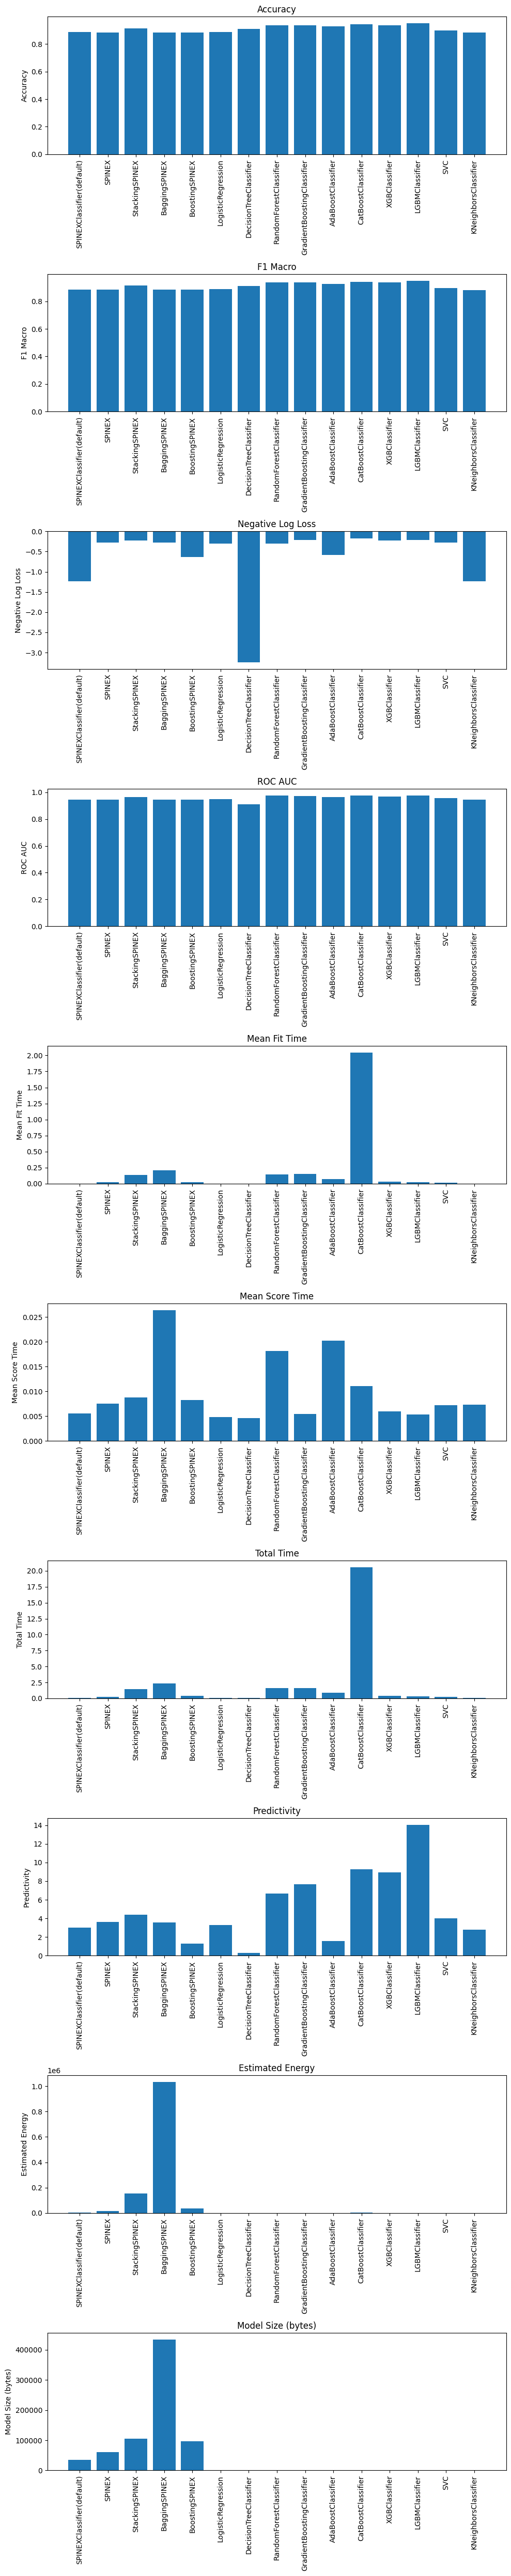

In [5]:
import matplotlib.pyplot as plt

# Define the metrics to plot
metrics_to_plot = [
    'Accuracy', 'F1 Macro', 'Negative Log Loss', 'ROC AUC',  # Added 'Negative Log Loss' and 'ROC AUC'
    'Mean Fit Time', 'Mean Score Time', 'Total Time', 'Predictivity', 'Estimated Energy', 'Model Size (bytes)'
]

# Create a figure and subplots for each metric
fig, axs = plt.subplots(len(metrics_to_plot), 1, figsize=(10, len(metrics_to_plot) * 5))

# Iterate through each metric and create a bar plot
for i, metric in enumerate(metrics_to_plot):
    # Extract the values for the current metric
    metric_values = [results[model_name][metric] for model_name in models.keys()]
    
    # Create the bar plot for the current metric
    axs[i].bar(models.keys(), metric_values)
    
    # Set the title and labels for the current subplot
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric)
    
    # Rotate the x-axis labels by 90 degrees
    axs[i].tick_params(axis='x', rotation=90)

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Show the plots
plt.show()


Ranked models for Accuracy:
  1. LGBMClassifier - Accuracy: 0.9500
  2. CatBoostClassifier - Accuracy: 0.9420
  3. RandomForestClassifier - Accuracy: 0.9360
  4. GradientBoostingClassifier - Accuracy: 0.9360
  5. XGBClassifier - Accuracy: 0.9360
  6. AdaBoostClassifier - Accuracy: 0.9260
  7. StackingSPINEX - Accuracy: 0.9140
  8. DecisionTreeClassifier - Accuracy: 0.9100
  9. SVC - Accuracy: 0.8980
  10. LogisticRegression - Accuracy: 0.8880
  11. SPINEXClassifier(default) - Accuracy: 0.8860
  12. SPINEX - Accuracy: 0.8840
  13. BaggingSPINEX - Accuracy: 0.8840
  14. BoostingSPINEX - Accuracy: 0.8840
  15. KNeighborsClassifier - Accuracy: 0.8820

Ranked models for F1 Macro:
  1. LGBMClassifier - F1 Macro: 0.9499
  2. CatBoostClassifier - F1 Macro: 0.9417
  3. RandomForestClassifier - F1 Macro: 0.9359
  4. GradientBoostingClassifier - F1 Macro: 0.9358
  5. XGBClassifier - F1 Macro: 0.9358
  6. AdaBoostClassifier - F1 Macro: 0.9258
  7. StackingSPINEX - F1 Macro: 0.9139
  8. DecisionTre

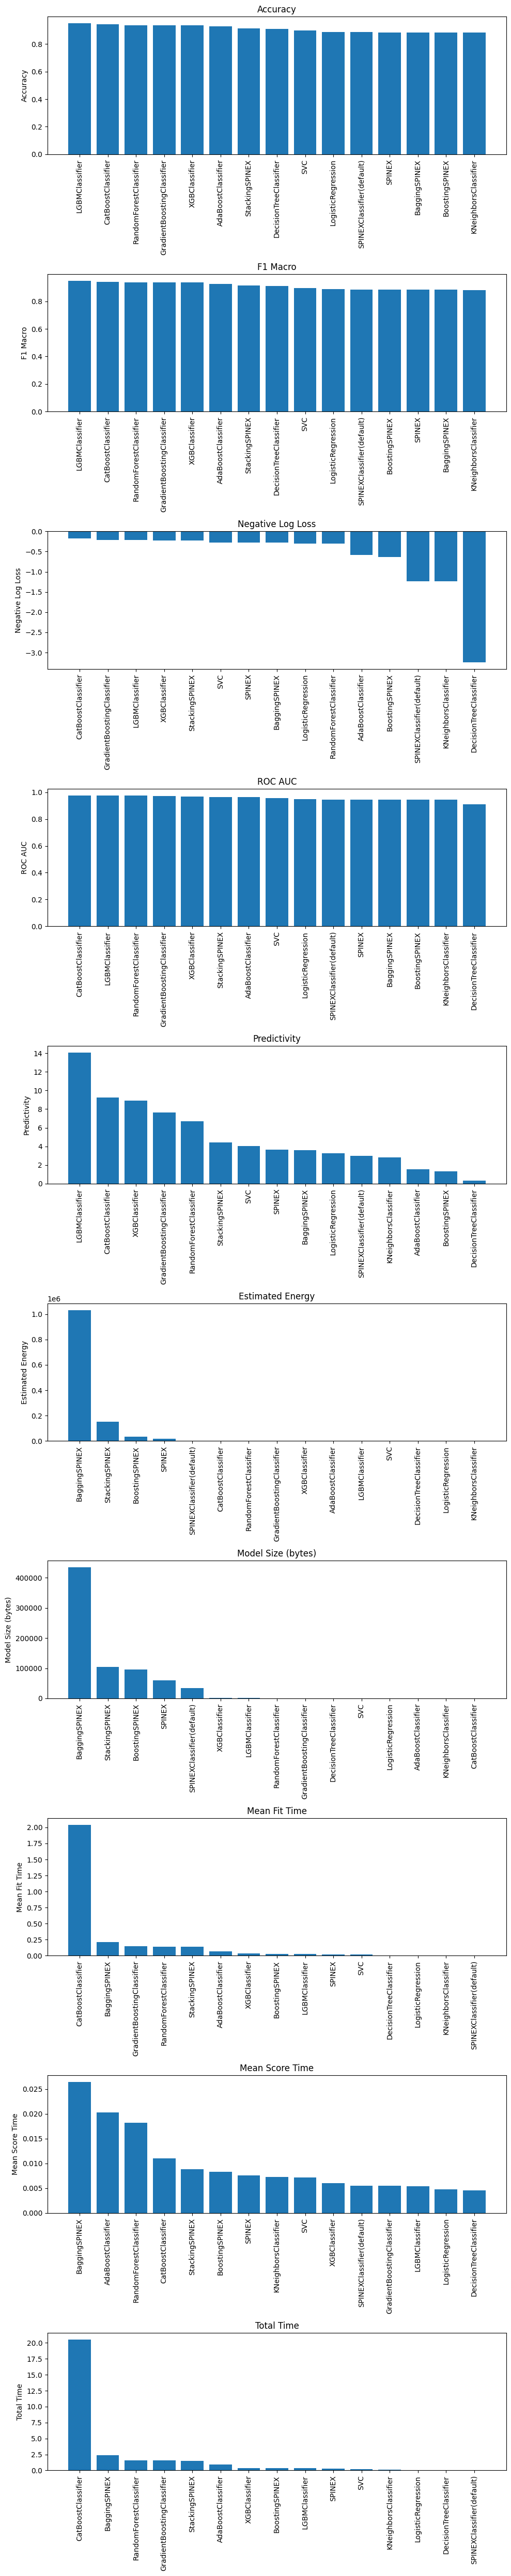

In [6]:
import matplotlib.pyplot as plt

# Define the metrics to plot
metrics_to_plot = [
    'Accuracy', 'F1 Macro', 'Negative Log Loss', 'ROC AUC',  # Existing metrics
    'Predictivity', 'Estimated Energy',  'Model Size (bytes)', # New metrics
    'Mean Fit Time', 'Mean Score Time', 'Total Time'
]

# Create a figure and subplots for each metric
fig, axs = plt.subplots(len(metrics_to_plot), 1, figsize=(10, len(metrics_to_plot) * 5))

# Iterate through each metric and create a bar plot
for i, metric in enumerate(metrics_to_plot):
    # Extract and sort the values for the current metric
    metric_values = [(model_name, results[model_name][metric]) for model_name in models.keys()]
    metric_values.sort(key=lambda x: x[1], reverse=True)  # Sort in descending order for best to worst

    # Print the ranked models for the current metric
    print(f"Ranked models for {metric}:")
    for rank, (model_name, metric_value) in enumerate(metric_values, start=1):
        print(f"  {rank}. {model_name} - {metric}: {metric_value:.4f}")
    print()
    
    # Create the bar plot for the current metric
    axs[i].bar([model_name for model_name, _ in metric_values], [metric_value for _, metric_value in metric_values])
    
    # Set the title and labels for the current subplot
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric)
    
    # Rotate the x-axis labels by 90 degrees
    axs[i].tick_params(axis='x', rotation=90)

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Show the plots
plt.show()


Normalized Feature Importances for SPINEXClassifier(default):
  Feature 0: 0.1580
  Feature 1: 0.0362
  Feature 2: 0.4570
  Feature 3: 0.1166
  Feature 4: 0.1128
  Feature 5: 0.1195
--------------------------------------------------
Normalized Feature Importances for SPINEX:
  Feature 0: 0.1548
  Feature 1: 0.0319
  Feature 2: 0.4622
  Feature 3: 0.1188
  Feature 4: 0.1129
  Feature 5: 0.1194
--------------------------------------------------
Normalized Feature Importances for StackingSPINEX:
  Feature 0: 0.1418
  Feature 1: 0.0504
  Feature 2: 0.5990
  Feature 3: 0.1298
  Feature 4: 0.0427
  Feature 5: 0.0364
--------------------------------------------------
Normalized Feature Importances for BaggingSPINEX:
  Feature 0: 0.1349
  Feature 1: 0.0229
  Feature 2: 0.5366
  Feature 3: 0.1164
  Feature 4: 0.1005
  Feature 5: 0.0887
--------------------------------------------------
Normalized Feature Importances for BoostingSPINEX:
  Feature 0: 0.1353
  Feature 1: 0.0203
  Feature 2: 0.5411

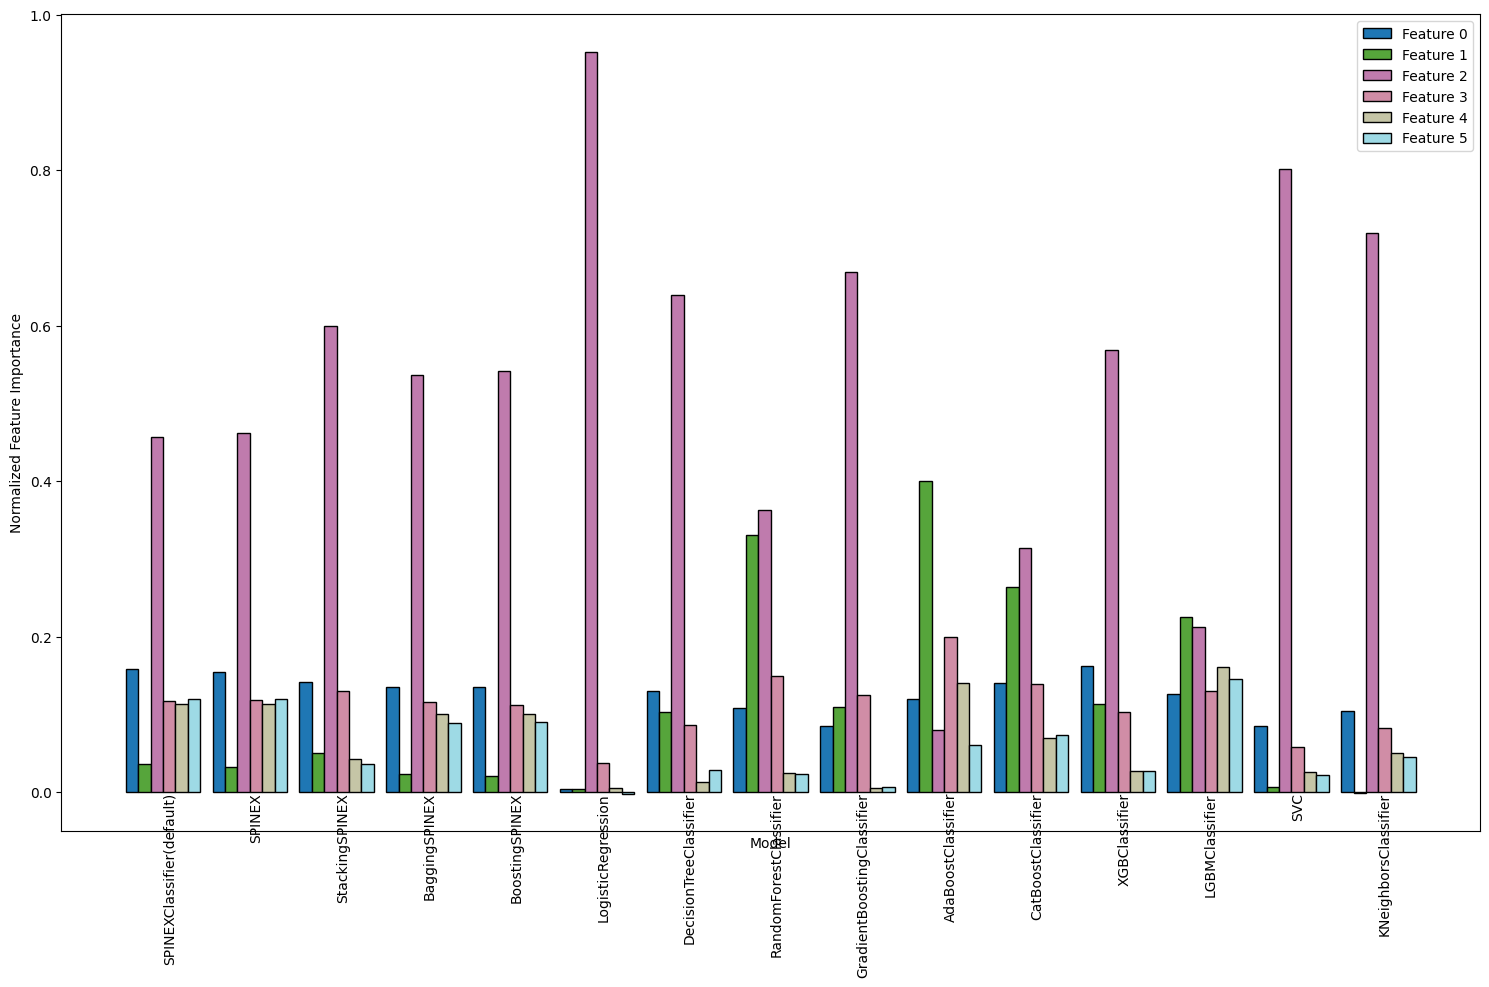

In [7]:
import numpy as np
import matplotlib.colors as mcolors
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def calculate_and_plot_feature_importances(models, X, y, selected_feature_indices=None):
    def normalize_importances(importances):
        return importances / np.sum(importances)

    # Initialize the feature_importances dictionary
    normalized_feature_importances = {}

    # Initialize variable to keep track of the maximum number of features
    max_features = 0

    # If selected_feature_indices is provided, use only the selected features
    if selected_feature_indices is not None:
        X = X[:, selected_feature_indices]

    # Calculate feature importances for each model
    for model_name, model in models.items():
        # Fit the model
        model.fit(X, y)
        
        # Check if the model is an instance of SPINEX
        if isinstance(model, SPINEX):
            # Calculate contributions for each feature
            predictions, contributions, _ = model.predict_contributions(X)

            # Calculate feature importances as the average absolute contributions
            feature_importances = np.mean(np.abs(contributions), axis=(1, 2))  # Average across instances and classes
            normalized_importances = feature_importances / np.sum(feature_importances)
        else:
            # Calculate feature importances
            if hasattr(model, 'feature_importances_'):
                raw_importances = model.feature_importances_
            else:
                r = permutation_importance(model, X, y, n_repeats=10, random_state=42, scoring='accuracy')
                raw_importances = r.importances_mean
            # Normalize the importances
            normalized_importances = raw_importances / np.sum(raw_importances)
        
        # Print normalized feature importances
        print(f"Normalized Feature Importances for {model_name}:")
        for i, importance in enumerate(normalized_importances):
            print(f"  Feature {i}: {importance:.4f}")
        print("-" * 50)

        # Update normalized_feature_importances dictionary
        normalized_feature_importances[model_name] = normalized_importances
        # Update max_features to keep track of the maximum number of features
        max_features = max(max_features, len(normalized_importances))
    
    # Plotting the normalized feature importances
    fig, ax = plt.subplots(figsize=(15, 10))

    # Set up the y-axis labels (feature indices)
    model_names = list(normalized_feature_importances.keys())

    # Create a colormap
    colormap = mcolors.LinearSegmentedColormap.from_list("custom", plt.cm.tab20.colors, N=max(max_features, 2))

    # Initialize a variable to keep track of the current x position for the bars
    current_x = 0

    # Plot the normalized feature importances for each feature
    for i, (model_name, importances) in enumerate(normalized_feature_importances.items()):
        num_features = len(importances)
        feature_indices = np.arange(num_features)
        bar_width = 1 / (max_features + 1)
        
        for j, importance in enumerate(importances):
            # Replace "nan" values with zeros
            if np.isnan(importance):
                importance = 0
            ax.bar(current_x + j * bar_width, importance, bar_width, color=colormap(j), 
                   label=f"Feature {j}" if i == 0 else None, edgecolor='black', linewidth=1)
       
        # Set the x-axis tick labels
        ax.text(current_x + (bar_width * num_features / 2), 0, model_name, rotation=90, ha='center', va='top')
        # Update the current x position
        current_x += num_features * bar_width + bar_width

    # Set the axis labels
    ax.set_ylabel("Normalized Feature Importance")
    ax.set_xlabel("Model")

    # Remove x-axis ticks
    ax.set_xticks([])

    # Add the legend
    # Generate dynamic legend labels based on the maximum number of features
    legend_labels = [f"Feature {i}" for i in range(max_features)]
    ax.legend(legend_labels)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Extract the indices of the selected features
selected_features_indices = preprocessor.selected_features_
calculate_and_plot_feature_importances(models, X, y, selected_feature_indices=selected_features_indices)



In [8]:
# Instantiate and fit the SPINEX model (code provided earlier)

# Obtain the average interaction effects using the get_global_interaction_effects method
# Note: Update this method call if the method name is different for the classification model
avg_interaction_effects = SPINEXClassifier.get_global_interaction_effects(X)

# Display the average interaction effects matrix
print("Average Interaction Effects:")
print(avg_interaction_effects)

# Obtain the impact of feature combinations using the feature_combination_impact_analysis method
# Note: Update this method call if the method name is different for the classification model
feature_combination_impact = SPINEXClassifier.feature_combination_impact_analysis(X)

# Display the impact of feature combinations
print("\nFeature Combination Impact Analysis:")
for comb, impact in feature_combination_impact:
    # Convert feature indices to names, assuming original names are like 'Feature 0', 'Feature 1', etc.
    feature_names = [f"Feature {i}" for i in comb]
    print(f"Feature Combination {feature_names}: Impact = {impact:.4f}")


Average Interaction Effects:
[[0.         0.5038475  0.51676544 0.52228756 0.51713797 0.51989883]
 [0.5038475  0.         0.50143326 0.50200373 0.50291522 0.5024393 ]
 [0.51676544 0.50143326 0.         0.51026636 0.50861802 0.51125823]
 [0.52228756 0.50200373 0.51026636 0.         0.5116333  0.51413991]
 [0.51713797 0.50291522 0.50861802 0.5116333  0.         0.52017857]
 [0.51989883 0.5024393  0.51125823 0.51413991 0.52017857 0.        ]]

Feature Combination Impact Analysis:
Feature Combination ['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']: Impact = 0.4530
Feature Combination ['Feature 0', 'Feature 2', 'Feature 3', 'Feature 4']: Impact = 0.4527
Feature Combination ['Feature 0', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']: Impact = 0.4493
Feature Combination ['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']: Impact = 0.4493
Feature Combination ['Feature 0', 'Feature 2', 'Feature 3', 'Feature 5']: Impact = 0.4299
Feature Combinat

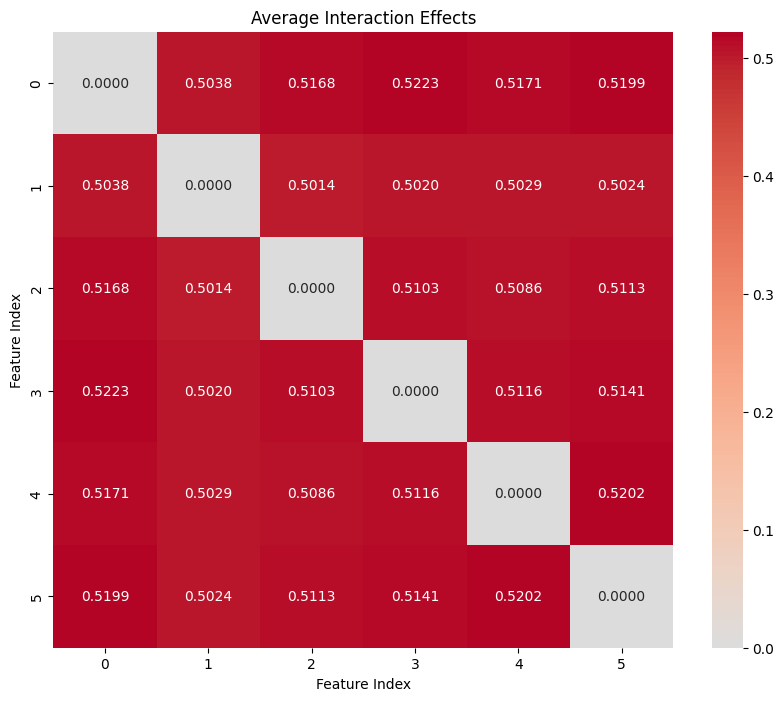

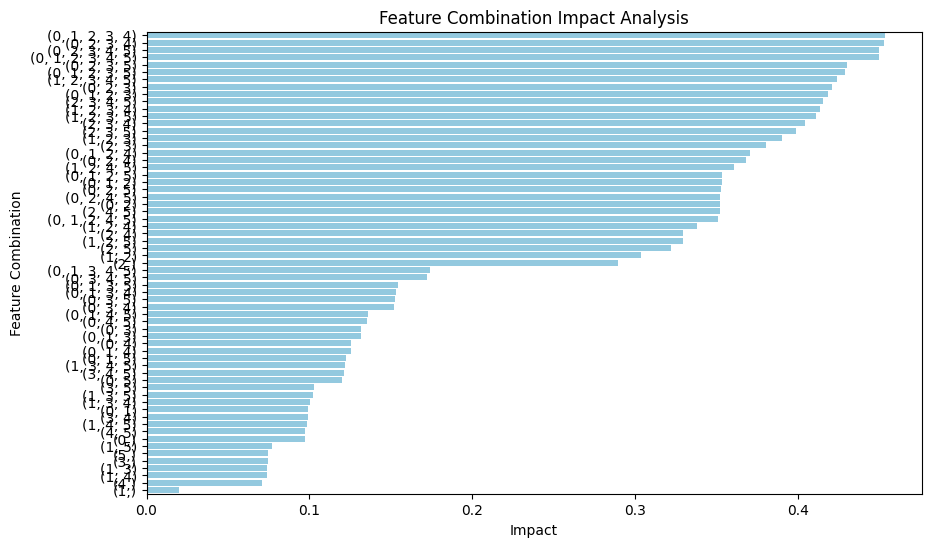

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain the average interaction effects using the get_global_interaction_effects method
avg_interaction_effects = SPINEXClassifier.get_global_interaction_effects(X)

# Plot the average interaction effects matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(avg_interaction_effects, annot=True, fmt='.4f', cmap='coolwarm', center=0)
plt.title("Average Interaction Effects")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.show()

# Obtain the impact of feature combinations using the feature_combination_impact_analysis method
feature_combination_impact = SPINEXClassifier.feature_combination_impact_analysis(X)

# Prepare data for plotting feature combination impact
feature_combinations = [str(comb) for comb, _ in feature_combination_impact]
impact_values = [impact for _, impact in feature_combination_impact]

# Plot the impact of feature combinations as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=impact_values, y=feature_combinations, orient='h', color='skyblue')
plt.title("Feature Combination Impact Analysis")
plt.xlabel("Impact")
plt.ylabel("Feature Combination")
plt.show()


Average Interaction Effects:
[[0.         0.5038475  0.51676544 0.52228756 0.51713797 0.51989883]
 [0.5038475  0.         0.50143326 0.50200373 0.50291522 0.5024393 ]
 [0.51676544 0.50143326 0.         0.51026636 0.50861802 0.51125823]
 [0.52228756 0.50200373 0.51026636 0.         0.5116333  0.51413991]
 [0.51713797 0.50291522 0.50861802 0.5116333  0.         0.52017857]
 [0.51989883 0.5024393  0.51125823 0.51413991 0.52017857 0.        ]]


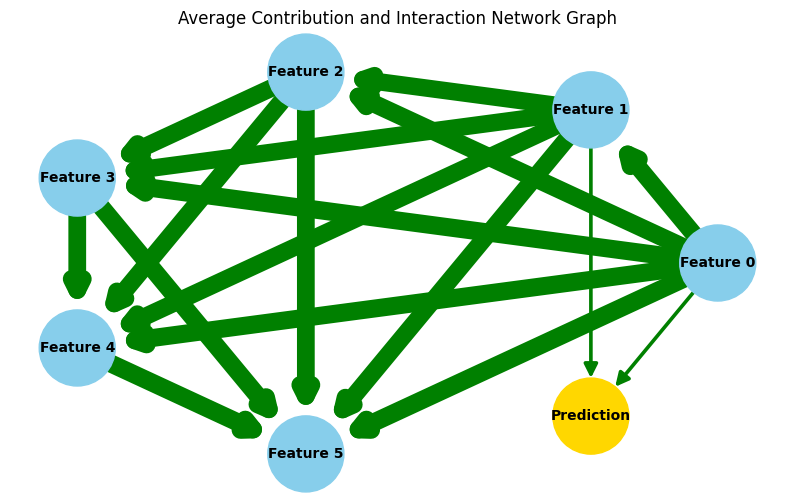

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_average_interaction_network(SPINEXClassifier, X, feature_names=None):
    # Predict contributions and interaction effects
    final_predictions, contributions, interaction_effects = SPINEXClassifier.predict_contributions(X)
    
    # Calculate the average contributions
    avg_contributions = np.mean(np.abs(contributions), axis=(0, 1))

    # Determine the number of selected features based on the shape of interaction_effects
    num_selected_features = interaction_effects.shape[0]

    # Automatically generate feature names if not provided
    if feature_names is None:
        feature_names = [f'Feature {j}' for j in range(num_selected_features)]

    # Calculate and print the average interaction effects matrix
    avg_interaction_effects = np.zeros((num_selected_features, num_selected_features))
    for i in range(num_selected_features):
        for j in range(i+1, num_selected_features):
            avg_interaction_effects[i, j] = np.mean(np.abs(interaction_effects[i][j]), axis=(0, 1))
            avg_interaction_effects[j, i] = avg_interaction_effects[i, j]
    print("Average Interaction Effects:")
    print(avg_interaction_effects)

    # Create a network graph
    G = nx.DiGraph()

    # Add nodes for features
    G.add_nodes_from(feature_names)

    # Add node for prediction
    G.add_node('Prediction')

    # Add edges for individual contributions
    for i, avg_contrib in enumerate(avg_contributions):
        G.add_edge(feature_names[i], 'Prediction', weight=abs(avg_contrib), sign=avg_contrib)

    # Add edges for pairwise interactions
    for i in range(num_selected_features):
        for j in range(i+1, num_selected_features):
            interaction_value = avg_interaction_effects[i, j]
            if interaction_value != 0:
                G.add_edge(feature_names[i], feature_names[j], weight=abs(interaction_value), sign=interaction_value)

    # Set edge colors based on the sign of interactions/contributions
    edge_colors = ["red" if G[u][v]['sign'] < 0 else "green" for u, v in G.edges()]

    # Set edge width based on the weight of interactions/contributions (scaled down by a factor)
    edge_widths = [G[u][v]['weight'] * 25 for u, v in G.edges()]

    # Set node colors (features in blue, prediction in yellow)
    node_colors = ['skyblue' if node in feature_names else 'gold' for node in G.nodes()]

    # Draw the network graph
    plt.figure(figsize=(10, 6))
    plt.gca().set_facecolor("#f0f0f0")
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors,
            font_size=10, font_weight='bold', font_color='black',
            edge_color=edge_colors, width=edge_widths, arrowstyle='-|>', arrowsize=20)
    plt.title('Average Contribution and Interaction Network Graph')
    plt.show()

# Plot the network graph for the average contributions and interactions
X_prioritized = None  # Set to None since we did not perform feature prioritization
plot_average_interaction_network(SPINEXClassifier, X_prioritized if X_prioritized is not None else X)


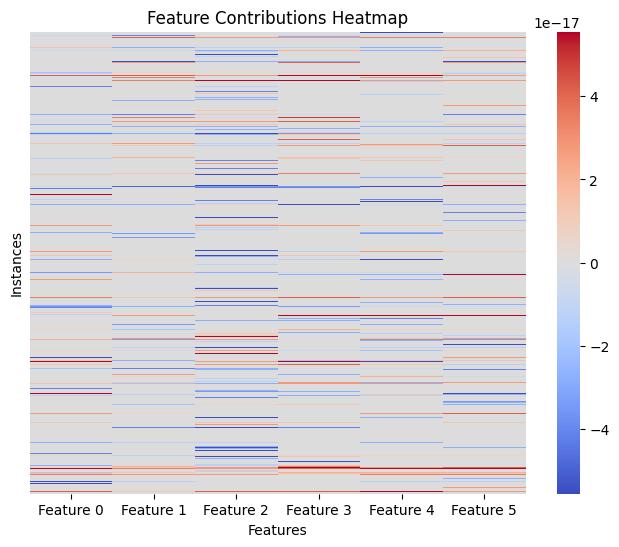

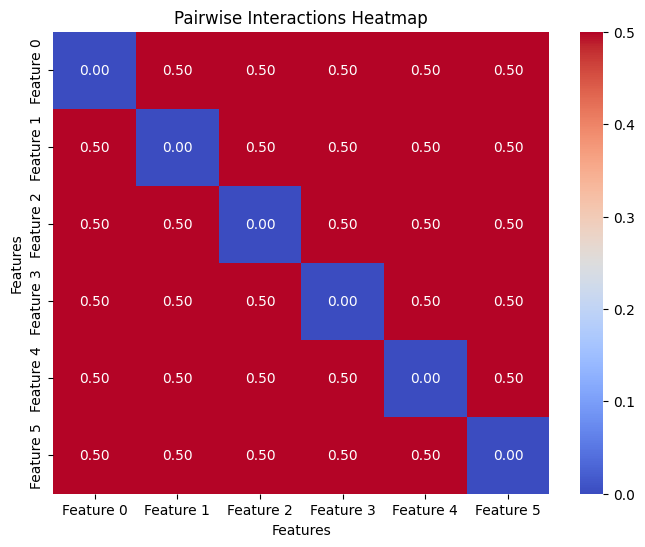

In [11]:
import seaborn as sns

def plot_contribution_heatmaps(SPINEXClassifier, X, feature_names=None):
    # Predict contributions and interaction effects
    final_predictions, contributions, interaction_effects = SPINEXClassifier.predict_contributions(X)
    
    # Determine the number of selected features
    num_selected_features = contributions.shape[0]
    
    # Automatically generate feature names if not provided
    if feature_names is None:
        feature_names = [f'Feature {j}' for j in range(num_selected_features)]

    # Calculate the mean contributions across classes for each feature and instance
    mean_contributions = contributions.mean(axis=2)
    
    # Create a heatmap of individual feature contributions
    plt.figure(figsize=(8, 6))
    sns.heatmap(mean_contributions.T, cmap='coolwarm', cbar=True, xticklabels=feature_names, yticklabels=False)
    plt.title('Feature Contributions Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Instances')
    plt.show()

    # Calculate the mean interaction effects for each pair of features
    pairwise_interactions = np.zeros((num_selected_features, num_selected_features))
    for i in range(num_selected_features):
        for j in range(i+1, num_selected_features):
            interaction_values = interaction_effects[i][j]
            pairwise_interactions[i, j] = np.mean(interaction_values)
            pairwise_interactions[j, i] = pairwise_interactions[i, j]

    # Create a heatmap of pairwise interactions
    plt.figure(figsize=(8, 6))
    sns.heatmap(pairwise_interactions, cmap='coolwarm', annot=True, fmt=".2f", cbar=True, xticklabels=feature_names, yticklabels=feature_names)
    plt.title('Pairwise Interactions Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

# Plot the contribution heatmaps for the entire dataset
plot_contribution_heatmaps(SPINEXClassifier, X)


In [12]:
# Define the models to evaluate (only the one with predict_contributions method)
spinex_models = {
    'SPINEX': SPINEXClassifier
}

# Select instances to predict
instance_index = [0, 2]  # Wrap the instance index in a list

# Get the feature contributions and interaction effects for the selected instances
for model_name, model in spinex_models.items():
    try:
        predictions, contributions, interaction_effects = model.predict_contributions(X[instance_index])
    except AttributeError:
        print(f"{model_name} does not have a predict_contributions method. Skipping...")
        continue

    # Print the ground truth, prediction values, feature contributions, and interaction effects for the selected instances
    for i, idx in enumerate(instance_index):
        print(f"\nInstance {i+1} with ground truth label {y[idx]}:")
        print(f"Prediction for instance {idx} using {model_name}: {predictions[i]}")

        # Print individual feature contributions
        print("Individual feature contributions:")
        for j in range(contributions.shape[0]):  # Iterate over all features
            contrib = contributions[j, i]  # Select contributions for the current instance
            print(f"Feature {j} contribution: {contrib}")

        # Calculate and print normalized contributions
        total_abs_contrib = np.sum(np.abs(contributions[:, i]), axis=0)  # Sum the absolute contributions for the current instance
        normalized_contributions = (np.abs(contributions[:, i]) / total_abs_contrib) * 100  # Normalize contributions
        print("Normalized feature contributions (percentage of total contribution):")
        for j, norm_contrib in enumerate(normalized_contributions.T):  # Iterate over normalized contributions for each class
            print(f"  Class {j}:")
            for k, norm_contrib_val in enumerate(norm_contrib):  # Iterate over normalized contributions for each feature
                print(f"    Feature {k} normalized contribution: {norm_contrib_val:.2f}%")

        # Calculate and print the sum of contributions
        sum_of_contributions = np.sum(contributions[:, i], axis=0)
        print(f"Sum of contributions: {sum_of_contributions}")

        # Print pairwise interaction effects, if available
        if len(interaction_effects[i]) > 0:  # Check if interaction_effects is not empty
            print("Pairwise interactions:")
            # Initialize the sum of interactions
            sum_of_interactions = 0
            # Count the number of unique pairwise interactions
            num_of_interactions = 0
            for j, interactions in enumerate(interaction_effects[i]):
                # Check if interactions is an iterable (such as an array or list)
                if hasattr(interactions, '__iter__'):
                    print(f"  Pairwise interactions for feature {j}: {interactions}")
                    # Add interactions to the sum of interactions
                    for k, interaction_value in enumerate(interactions):
                        if j != k:  # Exclude self-interactions
                            sum_of_interactions += interaction_value
                            num_of_interactions += 1
                else:
                    # If interactions is not an iterable, skip it
                    continue

            # Calculate and print the sum and mean of interactions
            abs_interaction_effects = np.abs(interaction_effects[i])
            sum_of_interactions = np.sum(abs_interaction_effects)
            mean_of_interactions = np.mean(abs_interaction_effects)
            print(f"Sum of interactions: {sum_of_interactions}")
            print(f"Mean of interactions: {mean_of_interactions}")
        else:
            print("Pairwise interaction effects: None")

        print("-" * 30)  # Single dashed line after feature contributions and interaction effects



Instance 1 with ground truth label 1:
Prediction for instance 0 using SPINEX: [0.12101173 0.87898827]
Individual feature contributions:
Feature 0 contribution: [-0.28115379  0.28115379]
Feature 1 contribution: [-0.01305158  0.01305158]
Feature 2 contribution: [-0.11614453  0.11614453]
Feature 3 contribution: [-0.21018536  0.21018536]
Feature 4 contribution: [-0.69023607  0.69023607]
Feature 5 contribution: [-0.81793885  0.81793885]
Normalized feature contributions (percentage of total contribution):
  Class 0:
    Feature 0 normalized contribution: 13.21%
    Feature 1 normalized contribution: 0.61%
    Feature 2 normalized contribution: 5.46%
    Feature 3 normalized contribution: 9.87%
    Feature 4 normalized contribution: 32.43%
    Feature 5 normalized contribution: 38.42%
  Class 1:
    Feature 0 normalized contribution: 13.21%
    Feature 1 normalized contribution: 0.61%
    Feature 2 normalized contribution: 5.46%
    Feature 3 normalized contribution: 9.87%
    Feature 4 norm

C:\Users\mznas\AppData\Local\Temp\ipykernel_12808\3331125724.py:30: RuntimeWarning: invalid value encountered in divide
  normalized_contributions = (np.abs(contributions[:, i]) / total_abs_contrib) * 100  # Normalize contributions


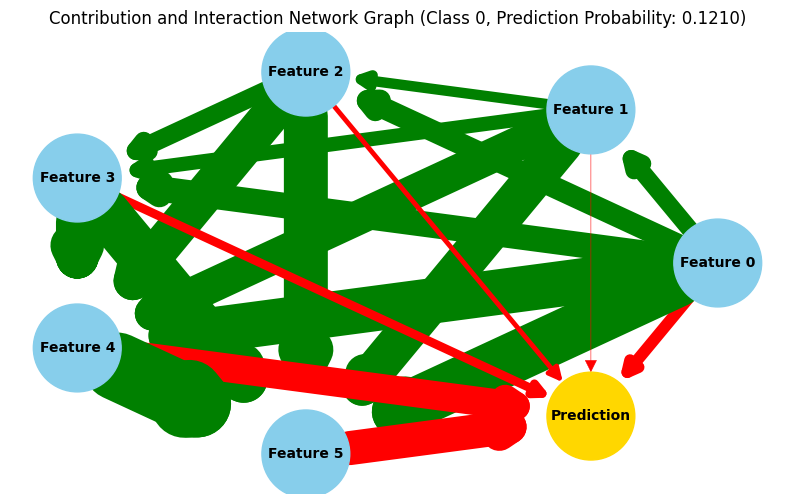

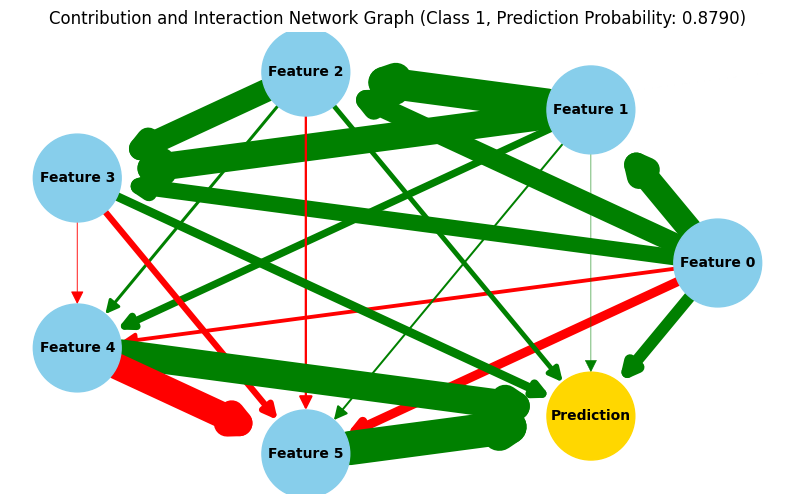

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def plot_interaction_network(SPINEXClassifier, X, feature_names=None, instance_index=0):
    # Predict contributions and interaction effects
    predictions, contributions, interaction_effects = SPINEXClassifier.predict_contributions(X)
    interaction_effects = np.array(interaction_effects, dtype=object)  # Fix ragged nested sequences warning

    # Determine the number of selected features
    num_selected_features = contributions.shape[0]

    # Automatically generate feature names if not provided
    if feature_names is None:
        feature_names = [f'Feature {j}' for j in range(num_selected_features)]

    # Loop over each class and create a network graph
    for class_idx in range(predictions.shape[1]):
        # Create a network graph
        G = nx.DiGraph()

        # Add nodes for features
        G.add_nodes_from(feature_names)

        # Add node for prediction
        G.add_node('Prediction')

        # Add edges for individual contributions
        for i, contrib in enumerate(contributions[:, instance_index, class_idx]):
            G.add_edge(feature_names[i], 'Prediction', weight=abs(contrib), sign=contrib)

        # Add edges for pairwise interactions
        for i in range(num_selected_features):
            for j in range(i+1, num_selected_features):
                interaction_value = interaction_effects[i, j][instance_index, class_idx]
                if interaction_value != 0:
                    G.add_edge(feature_names[i], feature_names[j], weight=abs(interaction_value), sign=interaction_value)

        # Set edge colors based on the sign of interactions/contributions
        cmap = mcolors.LinearSegmentedColormap.from_list("", ["red", "white", "green"])
        edge_colors = [cmap(G[u][v]['sign'] / 0.01 + 0.5) for u, v in G.edges()]

        # Set edge width based on the weight of interactions/contributions (scaled down by a factor)
        edge_widths = [G[u][v]['weight'] * 30 for u, v in G.edges()]

        # Set node colors (features in blue, prediction in yellow)
        node_colors = ['skyblue' if node in feature_names else 'gold' for node in G.nodes()]

        # Draw the network graph
        plt.figure(figsize=(10, 6))
        plt.gca().set_facecolor("#f0f0f0")
        pos = nx.circular_layout(G)
        nx.draw(G, pos, with_labels=True, node_size=4000, node_color=node_colors,
                font_size=10, font_weight='bold', font_color='black',
                edge_color=edge_colors, width=edge_widths, arrowstyle='-|>', arrowsize=20)
        plt.title(f'Contribution and Interaction Network Graph (Class {class_idx}, Prediction Probability: {predictions[instance_index, class_idx]:.4f})')
        plt.show()

# Plot the network graphs for the first instance
plot_interaction_network(SPINEXClassifier, X, instance_index=0)


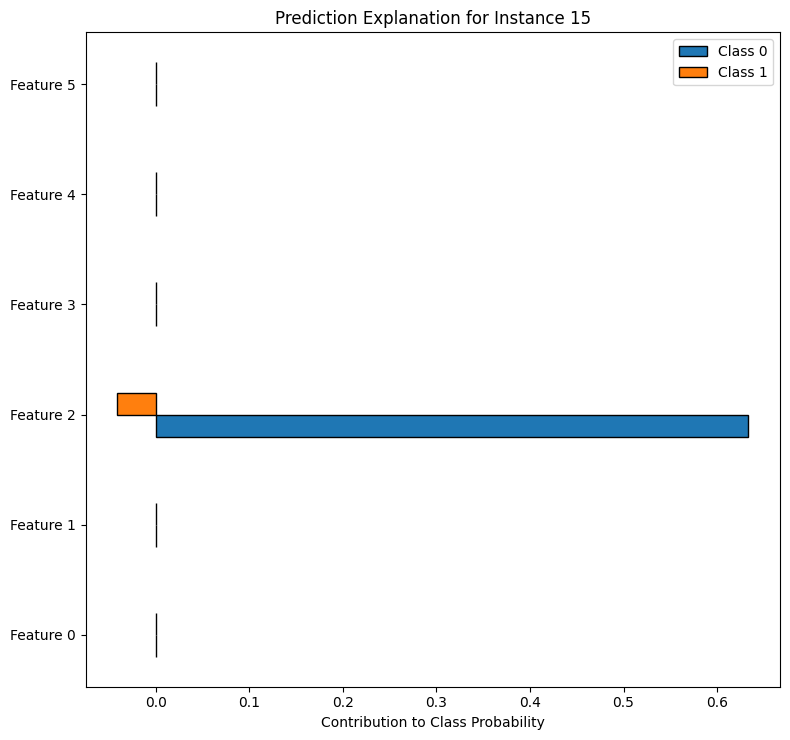

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_contributions_chart(contributions, class_probs, feature_names, class_labels, instance_idx, selected_features=None):
    # Filter contributions and feature names based on selected_features (if provided)
    if selected_features is not None:
        contributions = contributions[selected_features, :]
        feature_names = [feature_names[i] for i in selected_features]
    
    num_features, num_classes = contributions.shape
    class_contributions = contributions * class_probs[np.newaxis, :]
    
    fig, ax = plt.subplots(figsize=(8, num_features * 1.25))  # Adjust figsize here
    for i in range(num_classes):
        ax.barh(np.arange(num_features) + 0.2 * (i - 0.5), class_contributions[:, i], height=0.2, label=f'Class {i}', edgecolor='black')
    
    # Add labels and title
    ax.set_xlabel('Contribution to Class Probability')
    ax.set_title(f'Prediction Explanation for Instance {instance_idx}')
    ax.set_yticks(np.arange(num_features))
    ax.set_yticklabels(feature_names)
    
    # Add legend
    ax.legend()
    
    # Display the chart
    plt.tight_layout()
    plt.show()

# Get the selected feature indices from the preprocessor
selected_features = preprocessor.selected_features_

# Generate default feature names for all features
all_feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Select an instance index for which you want to explain the prediction
instance_index = 15  # You can choose any index from the dataset

# Get the prediction, contributions, and interaction effects for the selected instance
final_probabilities, contributions, interaction_effects = SPINEXClassifier.predict_contributions(X, instances_to_predict=[instance_index])

# Reshape the contributions array to ensure features are along the first dimension
contributions = contributions[:, 0, :].squeeze()

# Extract the class probabilities for the selected instance (use index 0 since there is only one instance in final_probabilities)
class_probs = final_probabilities[0]

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Use the plot_class_contributions_chart function to visualize the contributions for both classes
plot_class_contributions_chart(contributions=contributions,
                               class_probs=class_probs,
                               feature_names=all_feature_names,
                               class_labels=class_labels,
                               instance_idx=instance_index,
                               selected_features=selected_features)  # Pass the selected features


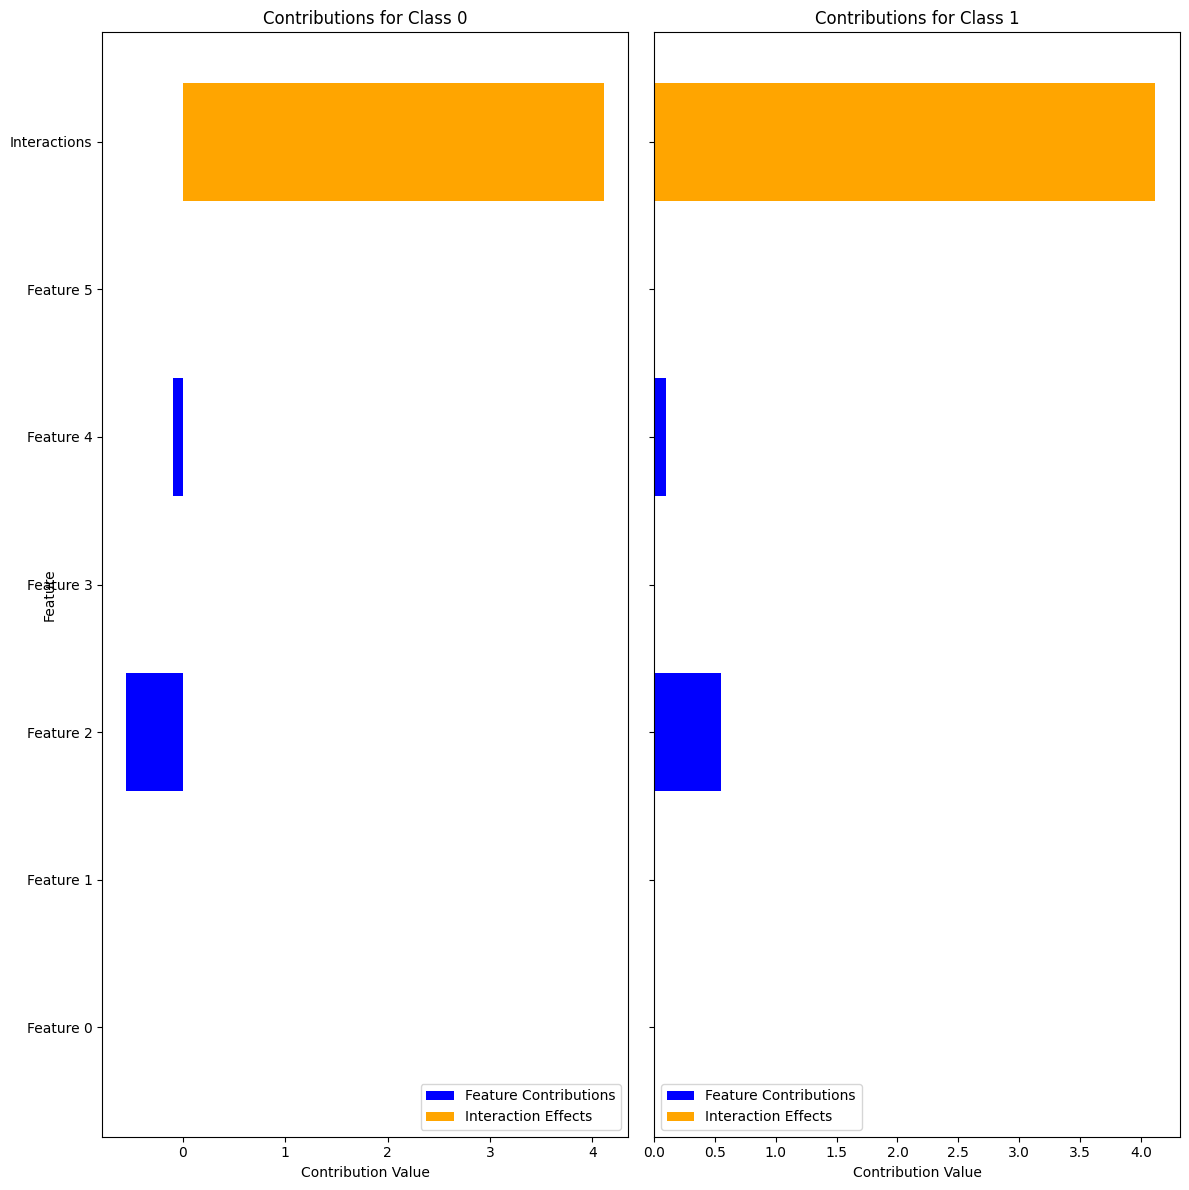

In [15]:
def plot_class_contributions_chart(contributions, interactions_sum, class_probs, feature_names, class_labels, instance_idx, selected_features=None):
    # Filter contributions, interactions, and feature names based on selected_features (if provided)
    if selected_features is not None:
        contributions = contributions[selected_features, :]
        interactions_sum = interactions_sum[selected_features, :]
        feature_names = [feature_names[i] for i in selected_features]  
    
    # Ensure that contributions is a 2D array
    contributions = np.atleast_2d(contributions)
    num_features, num_classes = contributions.shape
    interactions_sum = interactions_sum.squeeze()
    
    # Create subplots for each class
    fig, axs = plt.subplots(1, num_classes, figsize=(12, num_features * 2), sharey=True)
    for i, ax in enumerate(axs):
        # Plot contributions for each feature
        ax.barh(feature_names, contributions[:, i], color='blue', label='Feature Contributions')
        # Plot interactions
        ax.barh('Interactions', interactions_sum[i], color='orange', label='Interaction Effects')
        # Set labels and title
        ax.set_xlabel('Contribution Value')
        ax.set_title(f'Contributions for {class_labels[i]}')
        ax.legend()
    
    # Add a ylabel for the entire figure
    fig.text(0.04, 0.5, 'Feature', va='center', rotation='vertical')
    
    # Display the chart
    plt.tight_layout()
    plt.show()

# Get the selected feature indices from the preprocessor
selected_features = preprocessor.selected_features_

# Generate default feature names for all features
all_feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Select an instance index for which you want to explain the prediction
instance_index = 10  # You can choose any index from the dataset

# Get the prediction, contributions, and interaction effects for the selected instance
final_probabilities, contributions, interaction_effects = SPINEXClassifier.predict_contributions(X, instances_to_predict=[instance_index])

# Reshape the contributions array to ensure features are along the first dimension and classes along the second dimension
contributions = contributions[:, 0, :].squeeze()

# Calculate the sum of interaction effects along the first dimension (features) for each class
interactions_sum = np.sum(interaction_effects, axis=0).squeeze()

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Extract the class probabilities for the selected instance (use index 0 since there is only one instance in final_probabilities)
class_probs = final_probabilities[0]

# Use the plot_class_contributions_chart function to visualize the contributions and interactions for both classes
plot_class_contributions_chart(contributions=contributions.squeeze(),
                               interactions_sum=interactions_sum,
                               class_probs=class_probs,  # Use class_probs here
                               feature_names=all_feature_names,  # Pass all_feature_names here
                               class_labels=class_labels,
                               instance_idx=instance_index,
                               selected_features=selected_features)  # Pass the selected features


In [16]:
from rulefit import RuleFit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a random forest base model
base_model = RandomForestClassifier(n_estimators=100, random_state=0)

# Instantiate RuleFit with the base model
rf = RuleFit(tree_generator=base_model, rfmode='classify')
rf.fit(X_scaled, y)

# Extract rules
rules = rf.get_rules()

# Filter out zero-coefficient rules
rules = rules[rules.coef != 0].sort_values(by='coef', ascending=False)

# Display the rules
print("Rule-based explanations:")
print(rules[['rule', 'coef']])


Rule-based explanations:
                                                   rule      coef
294   feature_4 > 0.9281878173351288 & feature_3 > -...  9.221481
322   feature_1 > 1.3567814230918884 & feature_1 > -...  6.873481
1031  feature_2 > -0.40871642529964447 & feature_1 <...  6.119642
779   feature_1 <= -0.05400276556611061 & feature_2 ...  4.235920
1216  feature_3 > -0.22500918339937925 & feature_3 <...  3.908483
...                                                 ...       ...
385   feature_0 > 0.5362633168697357 & feature_3 <= ... -4.685776
860   feature_4 <= 1.9381036758422852 & feature_2 > ... -4.828246
1384  feature_1 <= -0.1604306325316429 & feature_1 >... -4.920752
1516  feature_0 > 1.5759932398796082 & feature_2 > 0... -5.080822
208   feature_0 <= 1.156432032585144 & feature_5 <= ... -6.595655

[342 rows x 2 columns]


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
logistic_model = LogisticRegression()

# Fit the model to the training data
logistic_model.fit(X_train, y_train)

# Make predictions on the training and testing data
y_pred_train = logistic_model.predict(X_train)
y_pred_test = logistic_model.predict(X_test)

# Calculate the accuracy scores
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Display the accuracy scores
print(f"Logistic model accuracy (training): {accuracy_train:.4f}")
print(f"Logistic model accuracy (testing): {accuracy_test:.4f}")

# Display the coefficients
for i, coef in enumerate(logistic_model.coef_[0]):
    print(f"Feature_{i}: {coef:.4f}")


Logistic model accuracy (training): 0.8925
Logistic model accuracy (testing): 0.8300
Feature_0: -0.1037
Feature_1: -0.2418
Feature_2: 2.4325
Feature_3: 0.6327
Feature_4: -0.1530
Feature_5: -0.1212


Decision Tree accuracy (training): 0.9500
Decision Tree accuracy (testing): 0.9100


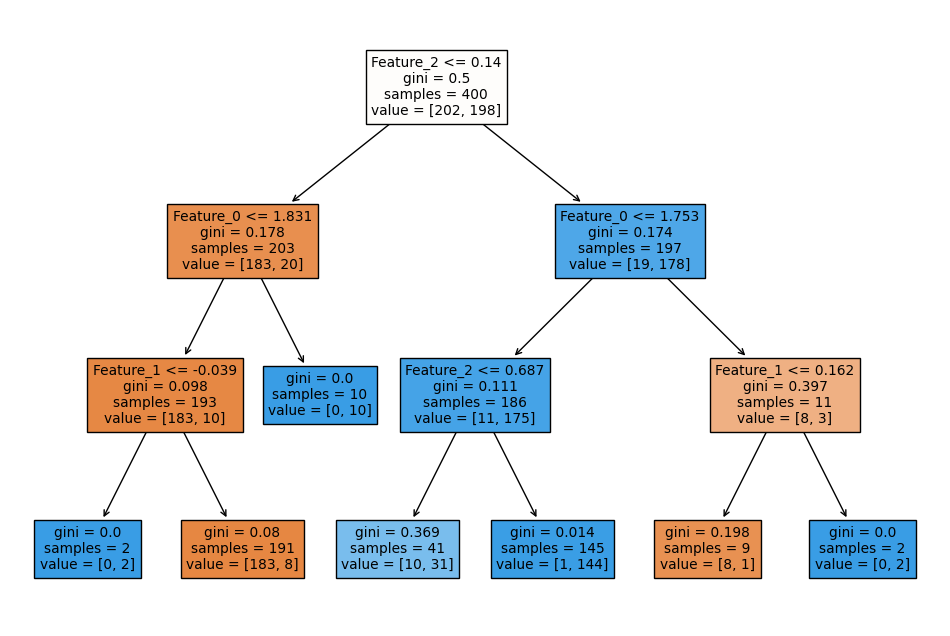

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.tree import plot_tree  # Import the plot_tree function

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
tree_classifier = DecisionTreeClassifier(max_depth=3)  # Choose a reasonable depth

# Fit the model to the training data
tree_classifier.fit(X_train, y_train)

# Make predictions on the training and testing data
y_pred_train = tree_classifier.predict(X_train)
y_pred_test = tree_classifier.predict(X_test)

# Calculate the accuracy scores
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Display the accuracy scores
print(f"Decision Tree accuracy (training): {accuracy_train:.4f}")
print(f"Decision Tree accuracy (testing): {accuracy_test:.4f}")

# Define feature names dynamically based on the number of features in X_train
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

# Plot the decision tree (requires graphviz)
plt.figure(figsize=(12, 8))
plot_tree(tree_classifier, feature_names=feature_names, filled=True)
plt.show()


In [19]:
from gplearn.genetic import SymbolicClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the SymbolicClassifier
symbolic_classifier = SymbolicClassifier(
    population_size=500,
    generations=25,
    stopping_criteria=0.01,
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    parsimony_coefficient=0.01,
    random_state=42
)

# Fit the symbolic classifier
symbolic_classifier.fit(X_train, y_train)

# Predict using the symbolic classifier
y_pred_train = symbolic_classifier.predict(X_train)
y_pred_test = symbolic_classifier.predict(X_test)

# Calculate the accuracy scores
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Print the results
print('Model: Symbolic Classification')
print(f'  Best Symbolic Expression: {symbolic_classifier._program}')
print(f'  Accuracy (training): {accuracy_train:.4f}')
print(f'  Accuracy (testing): {accuracy_test:.4f}')

# Print the equation for the symbolic classifier model
print(f"  Equation: {symbolic_classifier._program}")


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.11           3.0474        3         0.271629         0.338569      8.62s
   1     5.58         0.724779        5         0.269519         0.254541      6.58s
   2     3.62         0.429775        5         0.243545         0.492308      6.02s
   3     3.38         0.430423        5         0.245304         0.476477      5.75s
   4     3.29         0.389352        5         0.248056         0.451714      5.46s
   5     3.42         0.426346        5         0.243494          0.49277      5.50s
   6     3.24         0.414897        5         0.241817         0.507856      4.88s
   7     3.24         0.362163        5         0.241366         0.511918      4.71s
   8     3.60          0.42143        5         0.248517         0.447557  

In [20]:
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

# Create a synthetic regression dataset
X, y = make_classification(n_samples=1000, n_features=6, n_classes=2, random_state=42)

#df = pd.read_csv('spinex2.csv')
#X=df.drop(['Output'],axis=1)
#y=df['Output']
#y = np.array(y)
#X = np.array(X)

# Instantiate the SPINEX class with default parameters
model_instance = SPINEX()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'distance_threshold': [0.05, 0.1, 0.2, 0.5, 1.0],
    'distance_threshold_decay': [0.05, 0.1, 0.5, 1.0],
    'ensemble_method': [None, 'bagging', 'boosting'],
    #'estimator': [LogisticRegression()],
    #'preprocessor': [None, YourPreprocessor()],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

# Step 5: Create the grid search object with ROC AUC as the scoring metric
kfold = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
grid_search = GridSearchCV(estimator=model_instance, param_grid=param_grid, cv=kfold, scoring='roc_auc')

# Step 6: Fit the grid search object to the data
grid_search.fit(X, y)

# Step 7: Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Step 8: Print the best score (ROC AUC)
print("Best ROC AUC score:", grid_search.best_score_)

# Step 9: Get the best estimator
best_model = grid_search.best_estimator_

# Step 10: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 11: Train the best model on the training data
best_model.fit(X_train, y_train)

# Step 12: Make predictions on the training set
y_train_pred = best_model.predict(X_train)

# Step 13: Calculate accuracy and ROC AUC for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred)

# Step 14: Make predictions on the testing set
y_test_pred = best_model.predict(X_test)

# Step 15: Calculate accuracy and ROC AUC for testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

# Step 16: Perform cross-validation using the best model
cv_scores_accuracy = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
cv_scores_roc_auc = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')

cv_scores_accuracyStratifiedKFold = cross_val_score(SPINEXClassifier, X, y, cv=kfold, scoring='accuracy')
cv_scores_aucStratifiedKFold = cross_val_score(SPINEXClassifier, X, y, cv=kfold, scoring='roc_auc')

# Step 17: Calculate and display the metrics
print("Training Accuracy: {:.4f}".format(train_accuracy))
print("Training ROC AUC: {:.4f}".format(train_roc_auc))
print("Testing Accuracy: {:.4f}".format(test_accuracy))
print("Testing ROC AUC: {:.4f}".format(test_roc_auc))
print("Cross-Validation Accuracy: {:.4f}".format(cv_scores_accuracy.mean()))
print("Cross-Validation ROC AUC: {:.4f}".format(cv_scores_roc_auc.mean()))
print("Cross-Validation StratifiedKFold - Cross-Validation Accuracy: {:.4f}".format(cv_scores_accuracyStratifiedKFold.mean()))
print("Cross-Validation StratifiedKFold - Cross-Validation AUC: {:.4f}".format(cv_scores_aucStratifiedKFold.mean()))



Best hyperparameters: {'distance_threshold': 0.05, 'distance_threshold_decay': 0.05, 'ensemble_method': None, 'metric': 'manhattan', 'n_neighbors': 20}
Best ROC AUC score: 0.9524924209683874
Training Accuracy: 1.0000
Training ROC AUC: 1.0000
Testing Accuracy: 0.9150
Testing ROC AUC: 0.9083
Cross-Validation Accuracy: 0.8830
Cross-Validation ROC AUC: 0.9528
Cross-Validation StratifiedKFold - Cross-Validation Accuracy: 0.8900
Cross-Validation StratifiedKFold - Cross-Validation AUC: 0.9408
